In [37]:
import nibabel as nib
import os
import numpy as np
import os.path as op
import scipy
import pandas as pd
import pickle
import scipy.stats
from ipyparallel import Client
from statsmodels.formula.api import ols
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
rc = Client()

In [3]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
subs = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)

In [4]:
def is_invertible(a):
    return a.shape[0] == a.shape[1] and np.linalg.matrix_rank(a) == a.shape[0]

In [5]:
def compute_inv_shrunk_covariance(x,mask):
    #see http://www.diedrichsenlab.org/pubs/Walther_Neuroimage_2016.pdf
    t,n = x.shape #t measurements by n voxels

    #demean
    x = x - x.mean(0)

    #compute covariance
    sample = (1.0/t) * np.dot(np.transpose(x),x)

    #copute prior
    prior = np.diag(np.diag(sample))

    #compute shrinkage
    d = 1.0/n * np.linalg.norm(sample - prior,ord = 'fro')**2
    y = np.square(x)
    r2 = 1.0/n/t**2 * np.sum(np.sum(np.dot(np.transpose(y),y)))- \
    1.0/n/t*np.sum(np.sum(np.square(sample)))

    #compute the estimator
    shrinkage = max(0,min(1,r2/d))
    sigma = shrinkage*prior + (1-shrinkage)*sample

    #compute the inverse
    if is_invertible(sigma) or mask != 'VTC_sim':
        inv_sigma = np.linalg.inv(sigma)
    else:
        inv_sigma = np.linalg.inv(prior) #univariate
    
    return inv_sigma

In [6]:
#make sure MTL masks are exclusive
def trim_mask(sub,mask,m):
    exclusions = overlap_masks[:]
    exclusions.remove(m)

    m1 = op.join(home_dir,'data', sub,  'masks', exclusions[0] +'.nii.gz')
    m1 = nib.load(m1).get_data().astype(bool)

    m2 = op.join(home_dir,'data', sub,  'masks', exclusions[1] +'.nii.gz')
    m2 = nib.load(m2).get_data().astype(bool)

    bad = np.logical_or(m1,m1)
    good = np.invert(bad)

    mask = np.logical_and(mask,good)
    return mask

In [7]:
def compute_inverse_sigma(sub,exp,smooth,masks):
    sub_path = op.join(home_dir,'analysis', exp, sub, 'reg','epi', smooth)
    for run in map(str,range(1,4)):
        res = op.join(sub_path, 'run_'  + run,'res4d_xfm.nii.gz')
        
        if op.exists(res):
            res = nib.load(res).get_data().astype(float)

            for m in masks:
                out_f = op.join(home_dir,'covariance','_'.join([exp,sub,run,m]) + '.txt')
                
                if not op.exists(out_f): #don't recompute
                    mask = op.join(home_dir,'data', sub,  'masks', m + '.nii.gz')
                    mask = nib.load(mask).get_data().astype(bool)
                    if m in overlap_masks:
                        mask = trim_mask(sub,mask,m)

                    x = res[mask]
                    x = np.transpose(x)

                    inv_sigma = compute_inv_shrunk_covariance(x,m)

                    inv_sigma = scipy.linalg.fractional_matrix_power(inv_sigma,.5) #take square root

                    np.savetxt(out_f,inv_sigma)

In [8]:
def delete_inverse_sigma(sub,exp,smooth,masks):
    for run in map(str,range(1,4)):
        for m in masks:
            out_f = op.join(home_dir,'covariance','_'.join([exp,sub,run,m]) + '.txt')
            if op.exists(out_f):
                os.remove(out_f)

In [9]:
def get_condition(i,single):
    if single:
        return cond_map[i], 1
    elif i < 11:
        cond = 'b_plus'
        trial = i
    elif i < 21:
        cond = 'c_plus'
        trial = i - 10
    elif i < 31:
        cond = 'c_minus'
        trial = i - 20
    elif i < 41:
        cond = 'b_minus'
        trial = i - 30
    return cond,trial

In [10]:
def extract_betas(sub,exp,smooth,masks,single = True):
    if single:
        nbetas = 4
    else:
        nbetas = 40
        exp_id = 'sim_4mm-betas'
            
    all_betas = []
    for m in masks:
        out_f = op.join(home_dir,'betas', '_'.join([exp_id,sub,smooth,m]) + '.csv')
        
        #extract saved betas
        if not op.exists(out_f):
            betas = {'sub':[],'mask':[],'run':[],'condition':[],'value':[],'trial':[],'voxel':[],'row':[]}
            sub_path = op.join(home_dir,'analysis', exp_id, sub, 'reg','epi', smooth )

            mask = op.join(home_dir,'data', sub,  'masks', m + '.nii.gz')
            mask = nib.load(mask).get_data().astype(bool)
            if m in overlap_masks:
                mask = trim_mask(sub,mask,m)


            for run in map(str,range(1,4)):
                run_dir = op.join(sub_path, 'run_'  + run)

                if os.path.exists(run_dir):

                    for i in range(1,nbetas + 1):
                        f = run_dir + '/cope' + str(i) + '_xfm.nii.gz'

                        cond, trial = get_condition(i,single)

                        #load stat image
                        stat = nib.load(f).get_data().astype(float)
                        stat = stat[mask]

                        for n,val in enumerate(stat):
                            betas['voxel'].append(n)                        
                            betas['sub'].append(sub)
                            betas['value'].append(val)
                            betas['mask'].append(m)
                            betas['run'].append(run)
                            betas['condition'].append(cond)
                            betas['trial'].append(trial)
                            betas['row'].append(i)
                else:
                    print run_dir

            betas = pd.DataFrame(betas)
            betas.to_csv(out_f,index = False)
            
        else: #load from disk
            betas = pd.read_csv(out_f)
            
        all_betas.append(betas)
    all_betas = pd.concat(all_betas)
    all_betas = all_betas.set_index(['sub', 'run','mask','condition','trial'])
    return all_betas

In [11]:
def prewhiten_betas(old_betas,sub,exp,smooth,masks,single = True):
    
    all_betas = []
    if not single:
        exp_id = 'sim_4mm-betas'
        
    for m in masks:
        out_f = op.join(home_dir,'betas', 'whitened','_'.join([exp_id,sub,smooth,m]) + '.csv')
        
        if op.exists(out_f):
            all_betas.append(pd.read_csv(out_f))
            
        else:
            betas = old_betas.xs(m, level='mask', axis=0)
            
            for run in map(str,range(1,4)):
                #load covariance
                inv_sigma = op.join(home_dir,'covariance','_'.join([exp,sub,run,m]) + '.txt')

                if op.exists(inv_sigma):
                    inv_sigma = np.loadtxt(inv_sigma)

                    for cond in conds:
                        for trial in range(1,11):
                            vals = betas.loc[(sub,int(run),cond,trial),'value'].values
                            whiten_vals = np.dot(vals,inv_sigma)
                            betas.loc[(sub,int(run),cond,trial),'value'] = whiten_vals
                else:
                    print 'no covariance file',inv_sigma
                    
            out_betas = pd.DataFrame(betas.to_records()) 
            out_betas['mask'] = m
            out_betas.to_csv(out_f,index = False)
            all_betas.append(out_betas)
        
    all_betas = pd.concat(all_betas)
    all_betas = all_betas.set_index(['sub', 'run','mask','condition','trial'])
    return all_betas

In [12]:
# def compute_rsa(sub,exp,masks,betas):
#     rsas = {}
#     for m in masks:
        
#         runs = list(set(map(lambda x: x[0],betas.loc[(sub)].index)))
#         nruns = len(runs)
#         rsa = np.zeros((nconds,nconds))

#         for i in range(1,nconds+1):
#             for j in range(1,nconds+1):
#                 corr = []
                
#                 corr.append(scipy.stats.pearsonr(betas.loc[(sub,'1',m,cond_map[i]),'value'].values,
#                                      betas.loc[(sub,'2',m,cond_map[j]),'value'].values))
#                 if i != j:
#                     corr.append(scipy.stats.pearsonr(betas.loc[(sub,'2',m,cond_map[i]),'value'].values,
#                                          betas.loc[(sub,'1',m,cond_map[j]),'value'].values))

#                 if nruns == 3:

#                     corr.append(scipy.stats.pearsonr(betas.loc[(sub,'1',m,cond_map[i]),'value'].values,
#                                          betas.loc[(sub,'3',m,cond_map[j]),'value'].values))
#                     corr.append(scipy.stats.pearsonr(betas.loc[(sub,'2',m,cond_map[i]),'value'].values,
#                                          betas.loc[(sub,'3',m,cond_map[j]),'value'].values))
#                     if i != j:
#                         corr.append(scipy.stats.pearsonr(betas.loc[(sub,'3',m,cond_map[i]),'value'].values,
#                                                          betas.loc[(sub,'1',m,cond_map[j]),'value'].values))
#                         corr.append(scipy.stats.pearsonr(betas.loc[(sub,'3',m,cond_map[i]),'value'].values,
#                                                          betas.loc[(sub,'2',m,cond_map[j]),'value'].values))
                       
#                 rsa[i-1,j-1]  = np.nanmean(corr)
#         rsas[m] = rsa
        
#     return rsas

In [13]:
def compute_rsa_onebeta(sub,exp,masks,betas):
    rsas = {}
    for m in masks:
        
        runs = list(set(map(lambda x: x[0],betas.loc[(sub)].index)))
        nruns = len(runs)
        rsa = np.zeros((nconds,nconds))

        for i in range(1,nconds+1):
            for j in range(1,nconds+1):
                corr = []
                
                corr.append(scipy.stats.pearsonr(betas.loc[(sub,1,m,cond_map[i]),'value'].values,
                                                 betas.loc[(sub,1,m,cond_map[j]),'value'].values))
                corr.append(scipy.stats.pearsonr(betas.loc[(sub,2,m,cond_map[i]),'value'].values,
                                                 betas.loc[(sub,2,m,cond_map[j]),'value'].values))

                if nruns == 3:

                    corr.append(scipy.stats.pearsonr(betas.loc[(sub,3,m,cond_map[i]),'value'].values,
                                                     betas.loc[(sub,3,m,cond_map[j]),'value'].values))
                       
                rsa[i-1,j-1]  = np.nanmean(corr)
        rsas[m] = rsa
        
    return rsas

In [14]:
def compute_rsa_betas(sub,exp,masks,betas):
    rsa_df = {'cond1':[],'cond2':[],'corr':[],'mask':[],'run':[],'sub':[]}
    runs = list(set(map(lambda x: x[0],betas.loc[(sub)].index))) #get runs
    
    for m in masks:
        
        for i in range(1,nconds+1):
            for j in range(1,nconds+1):
                
                if i<= j:
                    for trial1 in range(1,11):
                        for trial2 in range(1,11):

                            if i !=j or trial1 < trial2:
                                for run in runs:
#                                     distance = scipy.stats.pearsonr(betas.loc[(sub,run,m,cond_map[i],trial1),'value'].values,
#                                                                  betas.loc[(sub,run,m,cond_map[j],trial2),'value'].values)[0]
                                    b1 = betas.loc[(sub,run,m,cond_map[i],trial1),'value'].values
                                    b2 = betas.loc[(sub,run,m,cond_map[j],trial2),'value'].values
                                    
                                    b1 = b1 - np.mean(b1)
                                    b2 = b2 - np.mean(b2)
                                    diff = b1 - b2
                                    distance = np.linalg.norm(diff) / len(diff)

                                    rsa_df['mask'].append(m)
                                    rsa_df['sub'].append(sub)
                                    rsa_df['cond1'].append(name_map[cond_map[i]] + str(trial1-1))
                                    rsa_df['cond2'].append(name_map[cond_map[j]] + str(trial2-1))
                                    rsa_df['corr'].append(distance)        
                                    rsa_df['run'].append(run)        
    return pd.DataFrame(rsa_df)


In [15]:
def compute_rsa_euclid(sub,exp,masks,betas):
    rsas = {}
    for m in masks:
        
        #Get crossval folds. Deal with unequal number of runs across subjects
        runs = list(set(map(lambda x: x[0],betas.loc[(sub)].index)))
        nruns = len(runs)
        if nruns == 3:
            train_runs = [['1','2'],['1','3'],['2','3']]
        elif nruns == 2:
            train_runs = [['1'],['2']]
        
        rsa = np.zeros((4,4,len(runs)))

        #loop through condition pairs
        for i in range(1,rsa.shape[0]+1):
            for j in range(1,rsa.shape[0]+1):
                if j < i:
                    #get euclidian distance between conditions for each run
                    run_euclid_dist = {}
                    for run in map(str,range(1,nruns+1)):
                        
                        cond1 = betas.loc[(sub,run,m,cond_map[i]),'value'].values
                        cond2 = betas.loc[(sub,run,m,cond_map[j]),'value'].values
                        
                        run_euclid_dist[run] = cond1 - cond2
                    
                    #do cross-validation
                    for n,train_run in enumerate(train_runs):
                        train_vector = []
                        test_vector = []
                    
                        for run in map(str,range(1,nruns+1)): 
                            if run in train_run:
                                train_vector.append(run_euclid_dist[run])
                            else:
                                test_vector.append(run_euclid_dist[run])

                        train_vector = np.mean(train_vector,0)
                        test_vector = np.mean(test_vector,0)
                        
                        diff = np.dot(train_vector,test_vector)
                        
                        rsa[i-1,j-1,n] = diff
        rsa = rsa.mean(2)
        rsas[m] = rsa
    return rsas

In [16]:
def run_sub(sub):
    out_f = op.join(home_dir,'rsa', sub + 'rsa_sim_whitened_euclid.pkl')

    if True:#not op.exists(out_f):

#         compute_inverse_sigma(sub,exp,smooth,masks)
        betas = extract_betas(sub,exp,smooth,masks,False)
        betas = prewhiten_betas(betas,sub,exp,smooth,masks,False)
#         delete_inverse_sigma(sub,exp,smooth,masks) #save disk space

        rsas = compute_rsa_betas(sub,exp,masks,betas)

        #write rsa to a file in case we have to stop the script
        output = open(out_f, 'wb')
        pickle.dump(rsas, output)
        output.close()  

In [17]:
masks = ['yeo17_ifs','mOFC_fill_sim','hipp','hipp_right','hipp_left',
         'entorhinal','peri_sim','para_sim',]
overlap_masks = ['peri_sim','para_sim','hipp']
masks = ['yeo17_ifs','mOFC_fill_sim','hipp','peri_sim','para_sim']
exp = 'sim_4mm-onebeta'
smooth = 'smoothed'
conds = ['b_plus','b_minus','c_plus','c_minus']
name_map = {'b_plus':'AB+_', 'c_minus':'AC-_','b_minus':'B-_','c_plus':'C+_'}
cond_map = {1:'b_plus',2:'c_minus',3:'b_minus',4:'c_plus'}
nconds = len(cond_map.keys())

# masks = ['hipp']
# run_sub('fd_104')

In [1557]:
dview = rc[0:33]
dview.block = True

dview.push(dict(home_dir=home_dir,
                masks = masks,
                exp = exp,
                conds = conds,
                smooth = smooth,
                cond_map = cond_map,
                name_map = name_map,
                nconds = nconds,
                get_condition = get_condition,
                overlap_masks = overlap_masks,
                prewhiten_betas = prewhiten_betas,
                compute_inv_shrunk_covariance = compute_inv_shrunk_covariance,
                compute_inverse_sigma = compute_inverse_sigma,
                is_invertible = is_invertible,
                extract_betas = extract_betas,
                delete_inverse_sigma = delete_inverse_sigma,
                trim_mask = trim_mask,
                compute_rsa_euclid = compute_rsa_euclid,
                compute_rsa_betas = compute_rsa_betas
                ))
dview.execute("import numpy as np")
dview.execute("import os.path as op")
dview.execute("import nibabel as nib")
dview.execute("import pandas as pd")
with dview.sync_imports():
    import os
    import numpy
    import scipy
    import scipy.stats
    import pickle
dview.map_sync(run_sub,subs)

importing os on engine(s)
importing numpy on engine(s)
importing scipy on engine(s)
importing scipy.stats on engine(s)
importing pickle on engine(s)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [18]:
#load RSAs from disk
all_rsas = []
for sub in subs:
    out_f = op.join(home_dir,'rsa', sub + 'rsa_sim.pkl')
    pkl_file = open(out_f, 'rb')
    rsa = pickle.load(pkl_file)
    all_rsas.append(rsa)
all_rsas = pd.concat(all_rsas)

In [19]:
#add in diagonal elements
new_df = pd.DataFrame()
for sub in subs:
    runs = set(all_rsas.loc[all_rsas['sub'] == sub,'run'])
    for m in masks:
        for run in runs:
            for cond in ['AB+_','B-_','AC-_','C+_']:
                for i in range(10):
                    row = pd.DataFrame({'mask':m,
                                       'sub':sub,
                                        'run':run,
                                        'cond1':cond + str(i),
                                        'cond2':cond + str(i),
                                        'corr': 1.0}, index = [0])
                    new_df = new_df.append(row)
fig_rsas = pd.concat([all_rsas, new_df])

In [20]:
fig_rsas = fig_rsas.set_index(['mask','run','sub'])

In [101]:
# tmp = fig_rsas.loc['hipp',1]
# # tmp.groupby(['cond1','cond2']).mean().unstack()
# for sub in set(tmp.index):
#     print sub, np.mean(tmp.loc[sub].groupby(['cond2','cond1']).mean().unstack().loc['C+_9'])

/home/iballard/.local/lib/python2.7/site-packages/pandas/core/index.py:4307: PerformanceWarning: indexing past lexsort depth may impact performance.
  PerformanceWarning)
/home/iballard/.local/lib/python2.7/site-packages/pandas/core/index.py:3293: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1
/home/iballard/.local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


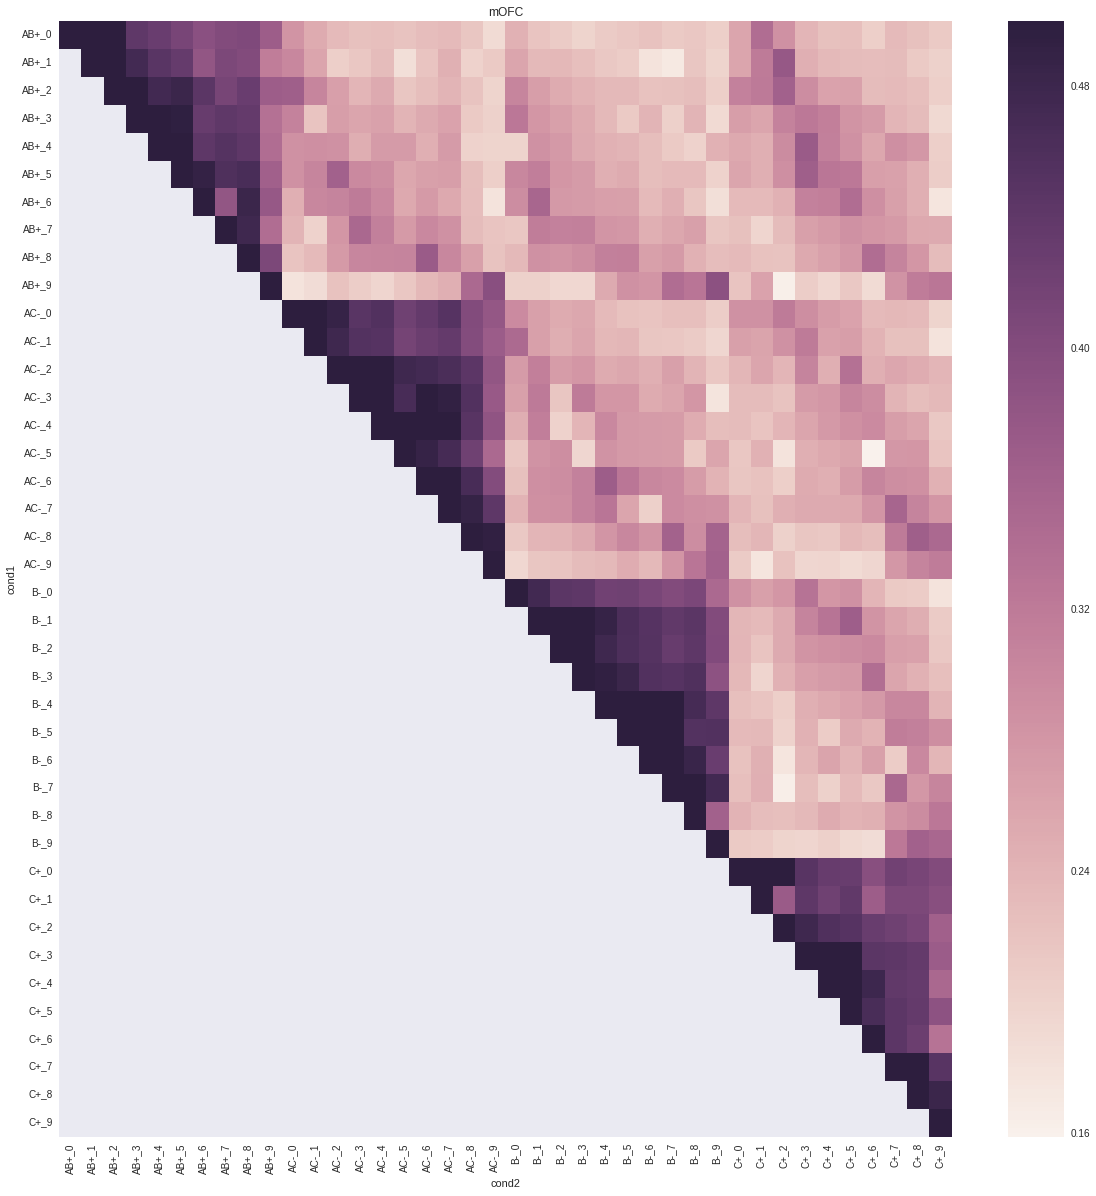

In [21]:
sns.set(rc={"figure.figsize": (20, 20)})
mean_rsa = fig_rsas.loc['hipp',2].groupby(['cond1','cond2']).mean()
mean_rsa = mean_rsa.unstack()['corr']
sns.heatmap(mean_rsa, vmax = .5)
plt.title('mOFC')
plt.savefig('/home/iballard/Dropbox/fd/figs/mOFC_RSA.png')

In [22]:
RL_next = pd.read_csv('/home/iballard/fdPE_V_nexttrial.csv')
RL_next = RL_next[RL_next['condition'] != 'feedback']
RL_next = RL_next.set_index(['exp','sub','run','condition'])
RL_next = RL_next.loc[('sim','fd_104')]

RL_std = pd.read_csv('/home/iballard/fdPE_V_trial.csv')
RL_std = RL_std[RL_std['condition'] != 'feedback']
RL_std = RL_std.set_index(['exp','sub','run','condition'])
RL_std = RL_std.loc[('sim','fd_104')]

for i in range(1,4):
    RL_std.loc[i,'trial'] = range(0,40)
RL_std.loc[(1,'c_plus')]

PE  duration  feedback_valence    onset  rew   rt  \
run condition                                                            
1   c_plus     1.000000         0               NaN   25.017    1  NaN   
    c_plus     0.600000         0               NaN   47.034    1  506   
    c_plus    -1.640000         0               NaN   59.047    0  NaN   
    c_plus     1.016000         0               NaN   74.060    1  952   
    c_plus     0.609600         0               NaN  122.712    1  573   
    c_plus     0.365760         0               NaN  163.363    1  939   
    c_plus    -1.780544         0               NaN  173.975    0  NaN   
    c_plus     0.931674         0               NaN  185.988    1  525   
    c_plus     0.559004         0               NaN  295.909    1  449   
    c_plus    -1.664598         0               NaN  351.970    0  NaN   

                      V  trial  
run condition                   
1   c_plus     0.000000      2  
    c_plus     0.400000      4  
    c_plus     0.640000      5  
    c_plus    -0.016000      7  
    c_plus     0.390400     12  
    c_plus     0.634240     17  
    c_plus     0.780544     18  
    c_plus     0.068326     20  
    c_plus     0.440996     33  
    c_plus     0.664598     39

# Conduct Univariate Analysis

In [305]:
def get_beta_model():
    reverse_name_map = {'AB+':'b_plus','B-':'b_minus','AC-':'c_minus','C+':'c_plus'}

    #initialize model
    model = {'response' : [],
    'valence' : [],
    'time' : [],
    'value_std' : [],
    'value_next' : [],
    'pe':[],
    'pe_unsigned':[],
    'run_idx' : [], 
    'y' : [],
    'cond':[],
    'sub':[],
    'mask':[]}

    for sub in subs:
        betas = extract_betas(sub,exp,smooth,masks,False)
#         betas = prewhiten_betas(betas,sub,exp,smooth,masks,False)
        runs = set(betas.index.levels[1].values)

        for run in runs:
            for m in masks:
                for cond in reverse_name_map.values():
                    cond_mean = betas.loc[(sub,run,m,cond)].groupby('row').mean()

                    for trial,val in enumerate(cond_mean['value']):
                        #get reward codings
                        r = RL_std.loc[(run,cond),'rew'].values[trial]
                        valence = int(r>0)
                        model['response'].append(r)
                        model['valence'].append(valence)

                        #trial diff (in real time)
                        t = RL_std.loc[(run,cond),'trial'].values[trial]
                        model['time'].append(t) 

                        #value 
                        v = RL_std.loc[(run,cond),'V'].values[trial]
                        model['value_std'].append(v)

                        #value difference
                        v = RL_next.loc[(run,cond),'V'].values[trial]
                        model['value_next'].append(v)

                        #PE
                        pe = RL_std.loc[(run,cond),'PE'].values[trial]
                        model['pe'].append(pe)
                        model['pe_unsigned'].append(abs(pe))

                        #corr
                        model['y'].append(val)

                        #cond labels
                        model['cond'].append(cond)

                        #book keeping
                        model['run_idx'].append(run)
                        model['sub'].append(sub)
                        model['mask'].append(m)

    model = pd.DataFrame(model)
    return model

In [306]:
beta_model = get_beta_model()

In [313]:
# beta_model = beta_model.set_index('mask')
# beta_model.loc['hipp']

In [386]:
mask_model = beta_model.loc[('peri_sim')].copy()

valence_map = {'b_plus':1,'c_plus':1,'c_minus':-1,'b_minus':-1}
numerosity_map = {'b_plus':1,'c_plus':-1,'c_minus':1,'b_minus':-1}
mask_model['cond_diff'] = [valence_map[x] for x in mask_model['cond'].values]
mask_model['nstims'] = [numerosity_map[x] for x in mask_model['cond'].values]

model_str = ['y ~ ']
regressors = ['cond_diff','nstims','pe','response']
mask_model['pe'] = vector_reject(mask_model['pe'],mask_model['response'])
# mask_model['pe_unsigned'] = vector_reject(mask_model['pe_unsigned'],mask_model['response'])
# mask_model['value_std'] = vector_reject(mask_model['value_std'],mask_model['response'])
# mask_model['value_next'] = vector_reject(mask_model['value_next'],mask_model['response'])

for r in regressors:
    model_str.append(r)

model_str = '+'.join(model_str)

# scipy.stats.pearsonr(mask_model['pe'] + mask_model['value_std'],mask_model['response'])
mixedfx = smf.mixedlm(model_str, mask_model, groups = mask_model['sub'], re_formula='~ pe')    
mixedfx = mixedfx.fit()
print mixedfx.summary()

/home/iballard/.local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     y           
No. Observations:      3760        Method:                 REML        
No. Groups:            32          Scale:                  1055375.4270
Min. group size:       80          Likelihood:             -31514.1620 
Max. group size:       120         Converged:              Yes         
Mean group size:       117.5                                           
-----------------------------------------------------------------------
                        Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------------------
Intercept                254.800  162.365  1.569 0.117  -63.430 573.031
cond_diff                 56.776   26.984  2.104 0.035    3.889 109.663
nstims                    -0.405   16.780 -0.024 0.981  -33.293  32.483
pe                       103.536  417.489  0.248 0.804 -714.727 921.798
response 

# Conduct RSA Analysis

In [136]:
def get_base_model(sub,mask): 
    reverse_name_map = {'AB+':'b_plus','B-':'b_minus','AC-':'c_minus','C+':'c_plus'}

    overlap_pairs = [['b_plus','b_minus'],
                    ['c_plus','c_minus'],
                    ['b_plus','c_minus']]
    overlap_pairs = [set(x) for x in overlap_pairs] #so order doesnt matter

    not_overlap_pairs = [['c_plus','b_minus'],
                         ['b_plus','c_plus'],
                      ['c_minus','b_minus']]
    not_overlap_pairs = [set(x) for x in not_overlap_pairs] #so order doesnt matter

    within_context_pairs = [['b_plus','c_minus'],
                           ['b_minus','c_plus']]
    within_context_pairs = [set(x) for x in within_context_pairs] #so order doesnt matter

    between_context_pairs = [['b_plus','b_minus'],
                            ['c_plus','c_minus'],
                            ['b_plus','c_plus'],
                            ['c_minus','b_minus']]
    between_context_pairs = [set(x) for x in between_context_pairs] #so order doesnt matter

    pairs = ['b_pluszzzc_minus','b_pluszzzb_minus', 'c_pluszzzc_minus','c_pluszzzb_minus',
             'c_pluszzzb_plus','b_minuszzzc_minus']

    #get dataframe
    sub_rsa = all_rsas.set_index(['mask','sub','run'])
    sub_rsa = sub_rsa.loc[(mask,sub)]
    runs = set(sub_rsa.index)

    #initialize model
    model = {'response' : [],
    'valence' : [],
    'identity' : [],
    'time' : [],
    'overlap' : [],
    'non_overlap' : [],
    'context' : [],
    'value_std' : [],
    'value_next' : [],
    'pe':[],
    'max_pe':[],
    'pe_unsigned':[],
    'pe_pos':[],
    'pe_neg':[],
    'pe_diff':[],
    'run_idx' : [], 
    'corr' : [],
    'cond1':[],
    'cond2':[]}
    for i in range(10):
        model['overlap_' + str(i)] = []
    for pair in pairs:
        model[pair] = []

    for run in runs:
        for c1, c2, r in zip(sub_rsa.loc[run,'cond1'].values,
                             sub_rsa.loc[run,'cond2'].values,
                             sub_rsa.loc[run,'corr'].values):

            #get variables in tidy format
            cond1, trial1 = c1.split('_')
            cond2, trial2 = c2.split('_')
            cond1 = reverse_name_map[cond1]
            cond2 = reverse_name_map[cond2]

            #get reward codings
            r1 = RL_std.loc[(run,cond1),'rew'].values[trial1]
            r2 = RL_std.loc[(run,cond2),'rew'].values[trial2]
            same = int(r1 == r2)
            val = int(same)
            if r1 < 1.0:
                val = 0
            model['response'].append(same)
            model['valence'].append(val)

            ##each condition
            for pair in pairs:
                if set(pair.split('zzz')) == set([cond1,cond2]):
                    model[pair].append(1)
                else:
                    model[pair].append(0)


            ##identity
            iden= int(cond1 == cond2)
            model['identity'].append(iden)

            #trial diff (in real time)
            t1 = RL_std.loc[(run,cond1),'trial'].values[trial1]
            t2 = RL_std.loc[(run,cond2),'trial'].values[trial2]
            tdiff = abs(t1 - t2)
            model['time'].append(tdiff) 
            
            #overlap
            ov = set([cond1,cond2]) in overlap_pairs
            non_ov = set([cond1,cond2]) in not_overlap_pairs
            for i in range(10):
                ov_trial = 0
                if ov and trial1 == trial2 and int(trial1) ==i:
                    ov_trial = 1
                elif non_ov and trial1 == trial2 and int(trial1) ==i:
                    ov_trial = -1
                model['overlap_' + str(i)].append(ov_trial)   
            model['overlap'].append(int(ov) - 3*int(non_ov))
            model['non_overlap'].append(int(non_ov))

            #context
            within = set([cond1,cond2]) in within_context_pairs
            between = set([cond1,cond2]) in between_context_pairs 
            model['context'].append(within - between)


            #value difference
            v1 = RL_std.loc[(run,cond1),'V'].values[trial1]
            v2 = RL_std.loc[(run,cond2),'V'].values[trial2]
            vdiff = -1 * abs(v1 - v2)
            model['value_std'].append(vdiff)
            
            #value difference
            v1 = RL_next.loc[(run,cond1),'V'].values[trial1]
            v2 = RL_next.loc[(run,cond2),'V'].values[trial2]
            vdiff = -1 * abs(v1 - v2)
            model['value_next'].append(vdiff)

            #PE difference
            v1 = RL_std.loc[(run,cond1),'PE'].values[trial1]
            v2 = RL_std.loc[(run,cond2),'PE'].values[trial2]
            vdiff = -1 * abs(v1 - v2)
            unsigned_vdiff = -1 * abs(abs(v1) - abs(v2))
            
            model['pe'].append(vdiff)
            model['pe_unsigned'].append(vdiff)
            model['max_pe'].append(max(abs(v1),abs(v2)))
            if v1 > 0 and v2 > 0:
                model['pe_pos'].append(vdiff)
                model['pe_neg'].append(0)
                model['pe_diff'].append(0)
            elif v1<0 and v2 < 0:
                model['pe_neg'].append(vdiff)
                model['pe_diff'].append(0)
                model['pe_pos'].append(0)
            else:
                model['pe_diff'].append(vdiff)
                model['pe_pos'].append(0)
                model['pe_neg'].append(0)
                
            #run
            model['run_idx'].append(run)

            #corr
            model['corr'].append(r)

            #cond labels
            model['cond1'].append(c1)
            model['cond2'].append(c2)

    model = pd.DataFrame(model)
    return model

In [137]:
base = get_base_model('fd_104','hipp')
mask_models={}
for mask in masks:
    all_models = {}

    for sub in subs:
        sub_rsa = all_rsas.set_index(['mask','sub','run'])
        sub_rsa = sub_rsa.loc[(mask,sub)]
        runs = sorted(set(sub_rsa.index))
        
        #deal with uneven number of runs
        base_runs = [1,2,3]
        sub_df = base.copy()
        if len(runs) != len(base_runs): #right number of runs
            bad_runs = set(runs) ^ set(base_runs)
            for bad_run in bad_runs:
                sub_df = sub_df[sub_df['run_idx'] != bad_run]
        all_models[sub] = sub_df

        corr = []
        for run in runs:
            r = sub_rsa.loc[run]['corr'].values
            corr.extend(r)
            
        all_models[sub]['corr'] = corr

    mask_models[mask] = dict(all_models)

/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:69: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:70: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:91: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:92: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:116: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7/s

In [25]:
def sigmoid(x):
  return 1.0 / (1 + np.exp(-x))

(-0.45870615088678623, 7.614892745228165e-42)


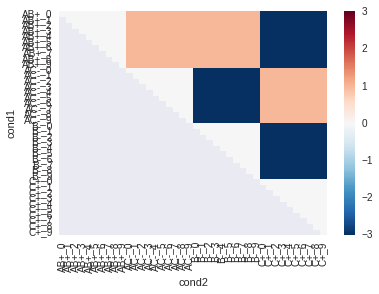

In [140]:
tmp  = mask_models['yeo17_ifs']['fd_104'].copy()
tmp = tmp[tmp['run_idx'] ==2]

tmp['value_std'] = tmp['value_std']*-1

print scipy.stats.pearsonr(tmp['value_next'],tmp['value_std'])
# tmp['value_next'] = tmp['value_next']*-1

# tmp['value'] = vector_reject(tmp['value'].values, tmp['response'].values)
# tmp['value'] = vector_reject(tmp['value'].values, tmp['valence'].values)

tmp['time0'] = map(int, tmp['time'] == 0)
tmp['response'] = scipy.stats.zscore(tmp['response'])
x_var = 'overlap'

tmp = tmp[['cond1','cond2',x_var]]
new_df = pd.DataFrame()
for cond in ['AB+_','B-_','AC-_','C+_']:
    for i in range(10):
        row = pd.DataFrame({x_var:0,
                            'cond1':cond + str(i),
                            'cond2':cond + str(i)},index = [0])
        new_df = new_df.append(row)
tmp = pd.concat([tmp,new_df])
tmp = tmp.groupby(['cond1','cond2']).mean().unstack()[x_var]
sns.heatmap(tmp)

(-0.45870615088678623, 7.614892745228165e-42)


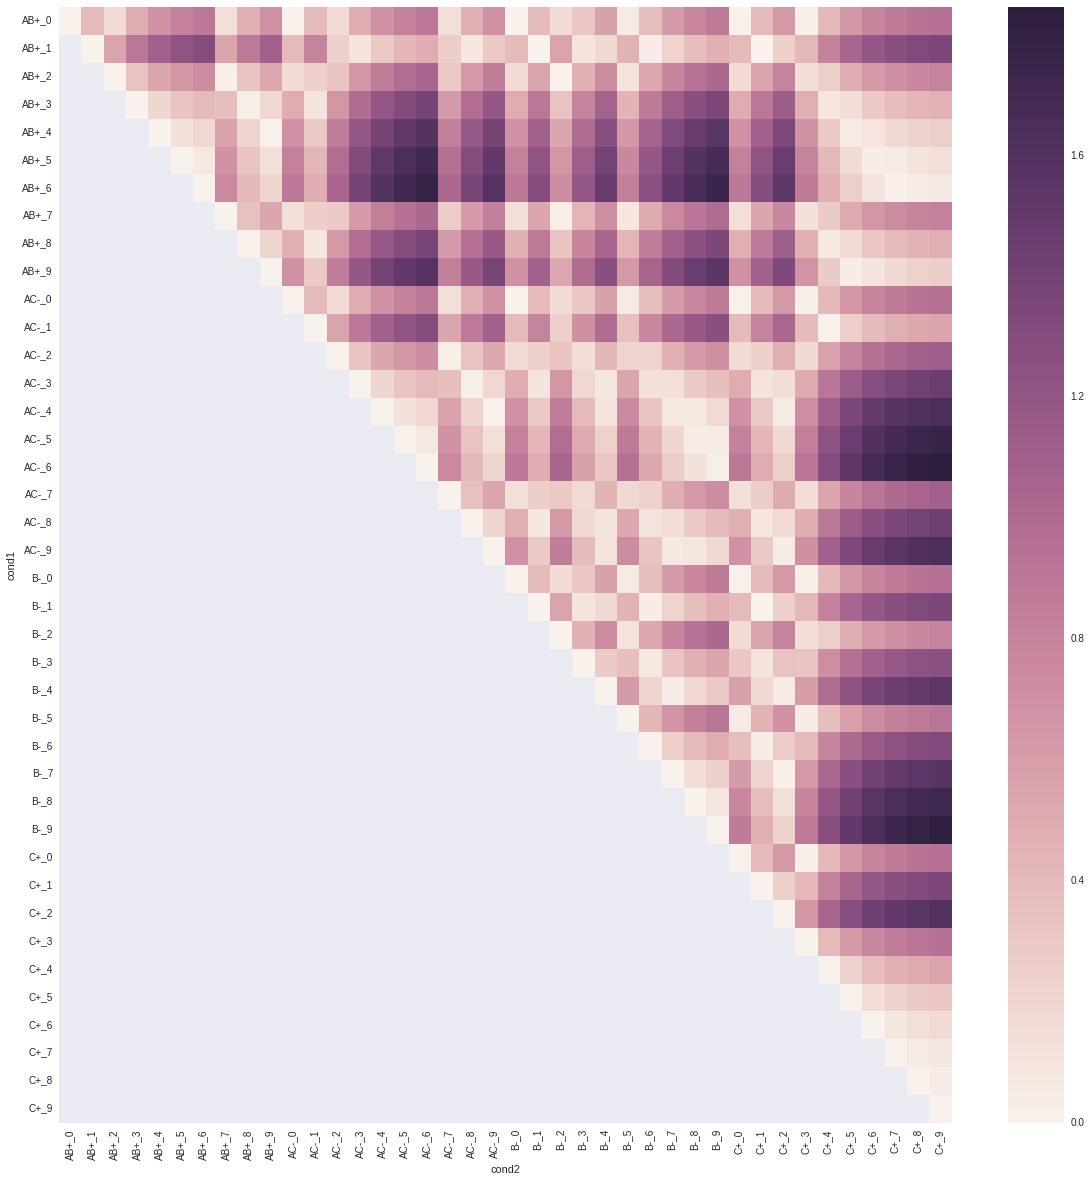

In [27]:
tmp  = mask_models['yeo17_ifs']['fd_104'].copy()
tmp = tmp[tmp['run_idx'] ==2]

tmp['value_std'] = tmp['value_std']*-1

print scipy.stats.pearsonr(tmp['value_next'],tmp['value_std'])
# tmp['value_next'] = tmp['value_next']*-1

# tmp['value'] = vector_reject(tmp['value'].values, tmp['response'].values)
# tmp['value'] = vector_reject(tmp['value'].values, tmp['valence'].values)

tmp['time0'] = map(int, tmp['time'] == 0)
x_var = 'value_std'

tmp = tmp[['cond1','cond2',x_var]]
new_df = pd.DataFrame()
for cond in ['AB+_','B-_','AC-_','C+_']:
    for i in range(10):
        row = pd.DataFrame({x_var:0,
                            'cond1':cond + str(i),
                            'cond2':cond + str(i)},index = [0])
        new_df = new_df.append(row)
tmp = pd.concat([tmp,new_df])
tmp = tmp.groupby(['cond1','cond2']).mean().unstack()[x_var]
sns.heatmap(tmp)

In [28]:
#project a onto be
def vector_reject(a,b): #a gives variance to be
    return a - (np.dot(a,b)/np.dot(b,b)) * b    

In [219]:
res = {'region':[],'sub':[], 'overlap':[], 'trial':[]}

for mask in masks:
    if mask != 'entorhinal':
        for sub in subs:
            m = mask_models[mask][sub].copy()


#             overlap = np.zeros(m.shape[0])
#             for i in range(10):
#                 overlap = overlap + m['overlap_' + str(i)].values
#             m = m[overlap != 0]
            
            m['run_idx'] = map(str,m['run_idx'])
            m['valence'] = scipy.stats.zscore(m['valence'])
            m['response'] = scipy.stats.zscore(m['response'])
            
            m['corr'] = map(np.arctanh,m['corr'])

            model = ols("corr ~ response + valence + pe + value_std + run_idx + overlap_0 + overlap_1 + overlap_2 + overlap_3 +overlap_4 + overlap_5 + overlap_6 + overlap_7 +overlap_8 + overlap_9", m)    
            fit = model.fit()

            for i in range(10):
                res['overlap'].append(fit.params['overlap_' + str(i)])
                res['sub'].append(sub)
                res['region'].append(mask)
                res['trial'].append(i)
res = pd.DataFrame(res)

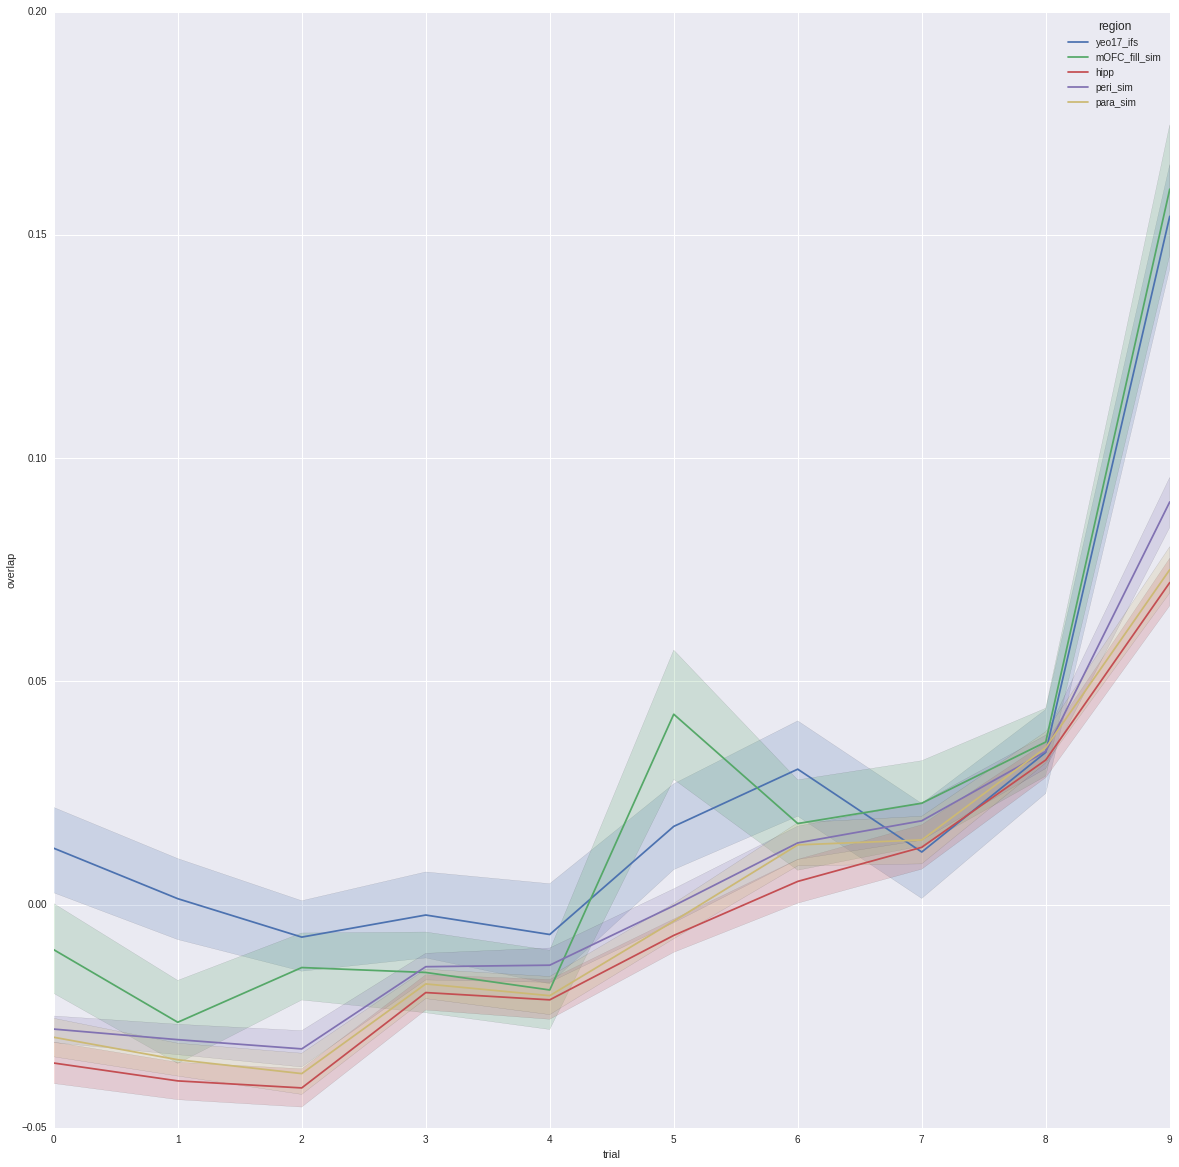

In [220]:
sns.tsplot(value = 'overlap',time = 'trial',unit = 'sub', condition = 'region', data = res)

In [143]:
value_regressors = ['value_next','value_std','pe','pe_unsigned']
regressors = ['response','valence','identity','overlap','pe','value_std','time','time2']
interactions = [('identity','time')]
for r in regressors:
    interactions.append(('mask',r))

#set up results dataframe
res = {'intercept':[],'region':[],'sub':[],'run':[]}
for r in regressors:
    res[r] = []
for tup in interactions:
    a,b = tup
    res[a + ':' + b] = []

model = []
for mask_idx,mask in enumerate(['hipp','peri_sim']):
    #deal with time
    for n,sub in enumerate(subs):
        m = mask_models[mask][sub].copy()
        m['time'] = scipy.stats.zscore(m['time'])
        m['time2'] = [x**2 for x in m['time']]

        #standardize regressors
        for r in regressors:
            m[r] = scipy.stats.zscore(m[r])
        
        #subjects
        m['sub'] = n
        m['mask'] = mask_idx *2 - 1
        
        #clean up dataframe
        all_cols = list(regressors)
        all_cols.extend(['corr','sub','mask'])
        m = m[all_cols]

        #orthogonalize
        for v_regress in value_regressors:
            if v_regress in regressors:
                m[v_regress] = vector_reject(m[v_regress],m['response'])
                m[v_regress] = vector_reject(m[v_regress],m['valence'])

        #process y
        m['corr'] = map(np.arctanh,m['corr'])
        model.append(m.copy())
        
model = pd.concat(model)

#set up model
model_str = ['corr ~ 1']
ignore_conds = []
for tup in interactions:
    a,b = tup
    ignore_conds.extend([a,b])
    model_str.append(a + '*' + b)
for r in regressors:
    if r not in ignore_conds:
        model_str.append(r)
model_str = '+'.join(model_str)


#     #compile results
#     res['intercept'].append(fit.params['Intercept'])
#     res['sub'].append(sub)
#     res['region'].append(mask)
#     res['run'].append(run)

#     for r in regressors:
#         res[r].append(fit.params[r])
#     for tup in interactions:
#         a,b = tup
#         res[a + ':' + b].append(fit.params[a + ':' + b])
# res = pd.DataFrame(res)

In [145]:
mixedfx = smf.mixedlm(model_str, model, groups = model['sub'])    
mixedfx = mixedfx.fit()
print mixedfx.summary()

/home/iballard/.local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: corr       
No. Observations:   146640  Method:             REML       
No. Groups:         32      Scale:              0.0091     
Min. group size:    3120    Likelihood:         135988.1094
Max. group size:    4680    Converged:          Yes        
Mean group size:    4582.5                                 
-----------------------------------------------------------
               Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept       0.294    0.008   37.947 0.000  0.279  0.310
identity        0.085    0.000  315.831 0.000  0.085  0.086
time           -0.045    0.000 -158.389 0.000 -0.046 -0.045
identity:time  -0.007    0.000  -26.932 0.000 -0.007 -0.006
mask           -0.027    0.000 -109.865 0.000 -0.028 -0.027
response        0.003    0.000   11.189 0.000  0.003  0.004
mask:response  -0.000    0.000   -0.566 0.572 -0.00

In [148]:
res = {'intercept':[],'response':[],'valence':[],'overlap':[],'pe':[],'time:pe':[],
       'pe_pos':[],'pe_neg':[],'pe_diff':[],
       'pe_unsigned':[],'time:pe_unsigned':[],'pe:identity':[],'max_pe':[],'overlap:pe':[],'overlap:max_pe':[],
       'overlap:value_std':[],'overlap:value_next':[],
       'time':[],'value_std':[],'value_next':[],'time:value_std':[],'time:value_next':[],
       'time:overlap':[],'context':[],'non_overlap':[],'value_std:identity':[],'value_next:identity':[],
       'time:identity':[],'time:response':[],'time:valence':[],
       'identity':[],'region':[],'sub':[]}

for mask in masks:
    if True:#mask == 'hipp':
        for sub in subs:
            m = mask_models[mask][sub].copy()
            m['value_std'] = scipy.stats.zscore(m['value_std'])
            m['value_next'] = scipy.stats.zscore(m['value_next'])

            m['pe'] = scipy.stats.zscore(m['pe'])
            m['max_pe'] = scipy.stats.zscore(m['max_pe'])
            m['pe_unsigned'] = scipy.stats.zscore(m['pe_unsigned'])
            
            m['valence'] = scipy.stats.zscore(m['valence'])
            m['response'] = scipy.stats.zscore(m['response'])
            
            m['overlap'] = scipy.stats.zscore(m['overlap'])
            m['context'] = scipy.stats.zscore(m['context'])

            m['value_std'] = vector_reject(m['value_std'],m['response'])
            m['value_std'] = vector_reject(m['value_std'],m['valence'])
            m['value_next'] = vector_reject(m['value_next'],m['response'])
            m['value_next'] = vector_reject(m['value_next'],m['valence'])
            m['pe'] = vector_reject(m['pe'],m['response'])
            m['pe'] = vector_reject(m['pe'],m['valence'])
            m['pe_unsigned'] = vector_reject(m['pe_unsigned'],m['response'])
            m['pe_unsigned'] = vector_reject(m['pe_unsigned'],m['valence'])
            m['value_std'] = vector_reject(m['value_std'],m['pe'])

            
            m['time'] = scipy.stats.zscore(m['time'])
            m['time2'] = [x**2 for x in m['time']]

            m['run_idx'] = map(str,m['run_idx'])
#             m['corr'] = 1 - m['corr']
            m['corr'] = scipy.stats.zscore(map(np.arctanh,m['corr']))

            model = ols("corr ~ response + valence + pe_pos + pe_neg + pe_diff + value_std + run_idx + overlap + time*identity + time2*identity",
                        m)    
#             model = ols("corr ~ run_idx + time + time2", m)    
#             model = ols("corr ~ run_idx + time + time0 +time1 + time2 + time3 + time4 + time5 + time6 +time7 +time8 +time9", m)    
            fit = model.fit()
#             mask_models[mask][sub]['resid'] = list(fit.resid)

            res['intercept'].append(fit.params['Intercept'])
            res['response'].append(fit.params['response'])
            res['valence'].append(fit.params['valence'])
            res['overlap'].append(fit.params['overlap'])
            res['non_overlap'].append(0)#fit.params['non_overlap'])
            res['identity'].append(fit.params['identity'])
            res['time'].append(fit.params['time'])
            res['value_std'].append(fit.params['value_std'])
            res['value_next'].append(0)#fit.params['value_next'])
            res['context'].append(0)#fit.params['context'])
            res['pe'].append(0)#fit.params['pe'])
            res['pe_pos'].append(fit.params['pe_pos'])
            res['pe_neg'].append(fit.params['pe_neg'])
            res['pe_diff'].append(fit.params['pe_diff'])
            res['max_pe'].append(0)#fit.params['max_pe'])
            res['pe_unsigned'].append(0)#fit.params['pe_unsigned'])
            res['time:pe'].append(0)#fit.params['time:pe'])
            res['time:pe_unsigned'].append(0)#fit.params['time:pe_unsigned'])
            res['time:value_next'].append(0)#fit.params['time:value_next'])
            res['time:value_std'].append(0)#fit.params['time:value_std'])
            res['time:overlap'].append(0)#fit.params['time:overlap'])
            res['overlap:pe'].append(0)#fit.params['overlap:pe'])
            res['overlap:value_std'].append(0)#fit.params['overlap:value_std'])
            res['overlap:value_next'].append(0)#fit.params['overlap:value_next'])
            res['overlap:max_pe'].append(0)#fit.params['overlap:max_pe'])
            res['pe:identity'].append(0)#fit.params['pe:identity'])
            res['value_std:identity'].append(0)#fit.params['value_std:identity'])
            res['value_next:identity'].append(0)#fit.params['value_next:identity'])
            res['time:identity'].append(fit.params['time:identity'])
            res['time:response'].append(0)#fit.params['time:response'])
            res['time:valence'].append(0)#fit.params['time:valence'])
            res['sub'].append(sub)
            res['region'].append(mask)

res = pd.DataFrame(res)

In [162]:
# resid_df = []
# for sub in subs:
#     tmp = mask_models['yeo17_ifs'][sub][['cond1','cond2','run_idx','resid']]
#     tmp['sub'] = sub
#     resid_df.append(tmp.copy())
# resid_df = pd.concat(resid_df)

In [1326]:
new_df = pd.DataFrame()
for run_idx in range(1,4):
    for cond in ['AB+_','B-_','AC-_','C+_']:
        for i in range(10):
            row = pd.DataFrame({'resid':0,
                                'run_idx':run_idx,
                                'cond1':cond + str(i),
                                'cond2':cond + str(i)},index = [0])
            new_df = new_df.append(row)
resid_df = pd.concat([resid_df,new_df])


In [ ]:
# # print resid_df[resid_df['run_id']]
# mean_rsa = resid_df.groupby(['cond1','cond2']).mean()
# mean_rsa = mean_rsa.unstack()['resid']
# sns.heatmap(mean_rsa)

In [207]:
res = {'response':[],'valence':[],'overlap':[],
       'time':[],'value_std':[],'time:value_std':[],'time:overlap':[],'context':[],
       'time:identity':[],'time:response':[],'time:valence':[],'identity:value':[],
       'identity':[],'region':[],'sub':[]}
pairs = ['b_pluszzzc_minus','b_pluszzzb_minus', 'c_pluszzzc_minus','c_pluszzzb_minus',
             'c_pluszzzb_plus','b_minuszzzc_minus']
for pair in pairs:
    res[pair] = []
    
for mask in masks:
    for sub in subs:
        m = mask_models[mask][sub].copy()
        m['value_std'] = -1 * m['value_std']


        m['value_std'] = scipy.stats.zscore(m['value_std'])
        m['valence'] = scipy.stats.zscore(m['valence'])
        m['identity'] = scipy.stats.zscore(m['identity'])
        m['response'] = scipy.stats.zscore(m['response'])

        m['time'] = -1*m['time'] + 9
        m['time'] = scipy.stats.zscore(m['time'])
        m['time2'] = [x**2 for x in m['time']]

        m['run_idx'] = map(str,m['run_idx'])
        m['corr'] = scipy.stats.zscore(map(np.arctanh,m['corr']))

        model = ols("corr ~ response + valence + run_idx + time*value_std  + time*identity + time2 + b_pluszzzc_minus + b_pluszzzb_minus + c_pluszzzc_minus + c_pluszzzb_minus + c_pluszzzb_plus + b_minuszzzc_minus",
                    m,)    
        fit = model.fit()

        for pair in pairs:
            res[pair].append(fit.params[pair])
        res['response'].append(fit.params['response'])
        res['valence'].append(fit.params['valence'])
        res['overlap'].append(0)#fit.params['overlap'])
        res['identity'].append(fit.params['identity'])
        res['time'].append(fit.params['time'])
        res['value_std'].append(fit.params['value_std'])
        res['context'].append(0)#fit.params['context'])
        res['time:value_std'].append(fit.params['time:value_std'])
        res['time:overlap'].append(0)#fit.params['time:overlap'])
        res['time:identity'].append(fit.params['time:identity'])
        res['identity:value'].append(0)#fit.params['identity:value'])
        res['time:response'].append(0)#fit.params['time:response'])
        res['time:valence'].append(0)#fit.params['time:valence'])
        res['sub'].append(sub)
        res['region'].append(mask)

res = pd.DataFrame(res)

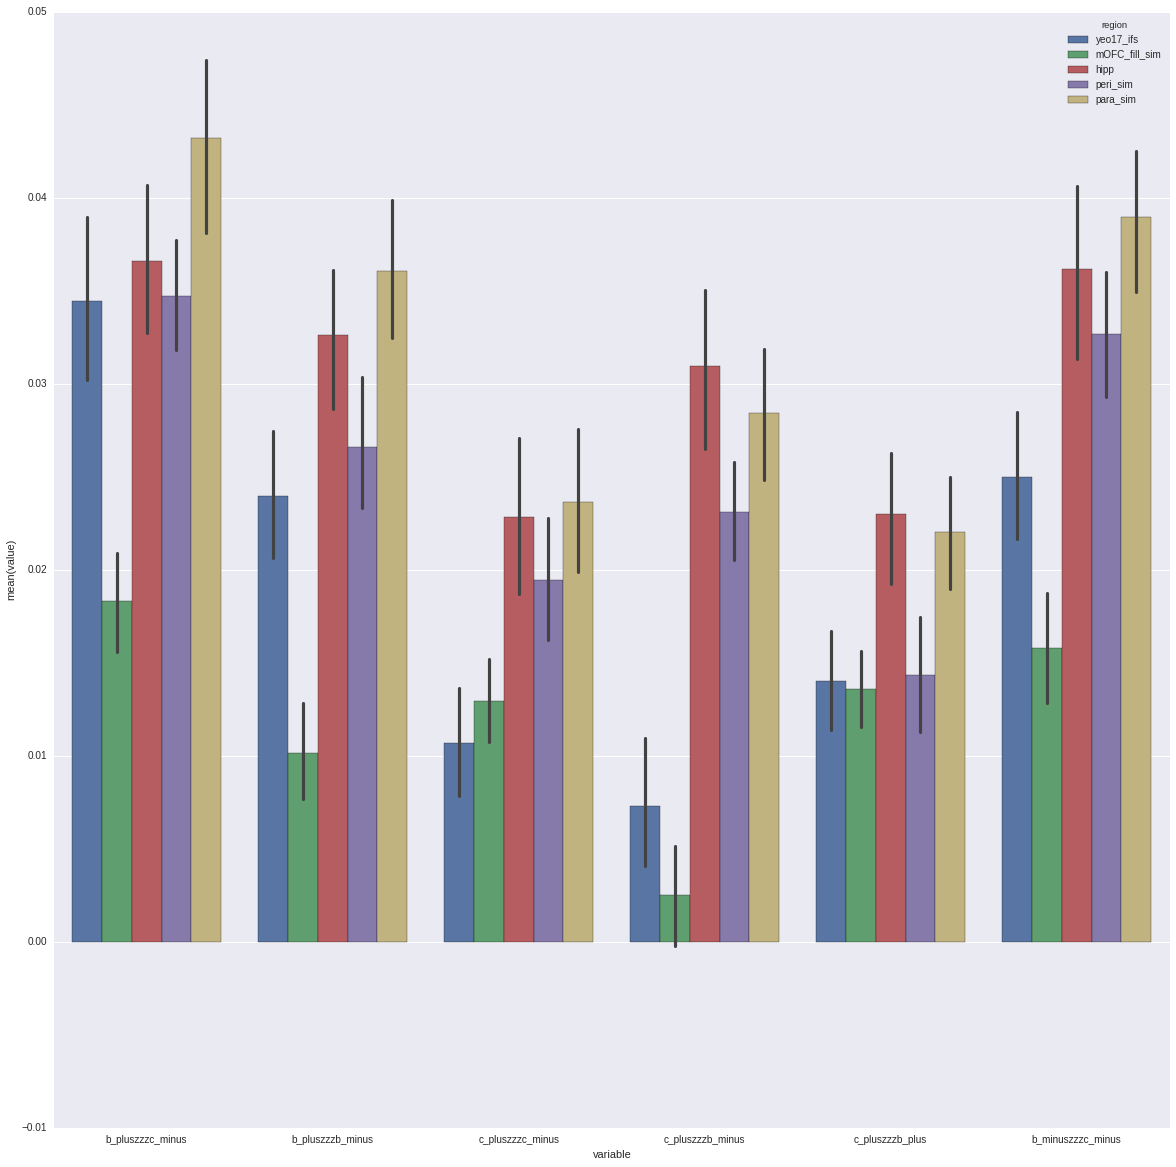

In [189]:
res_melt = pd.melt(res, id_vars=['region'], value_vars=pairs)
    overlap_pairs = [['b_plus','b_minus'],
                    ['c_plus','c_minus'],
                    ['b_plus','c_minus']]
    
sns.barplot(x='variable',y='value',hue = 'region',data = res_melt, ci = 68)

In [212]:
scipy.stats.ttest_rel(res.loc[res['region'] == 'mOFC_fill_sim','overlap'].values,
                        res.loc[res['region'] == 'para_sim','overlap'].values)

Ttest_relResult(statistic=0.50301198203535802, pvalue=0.61851115428105152)

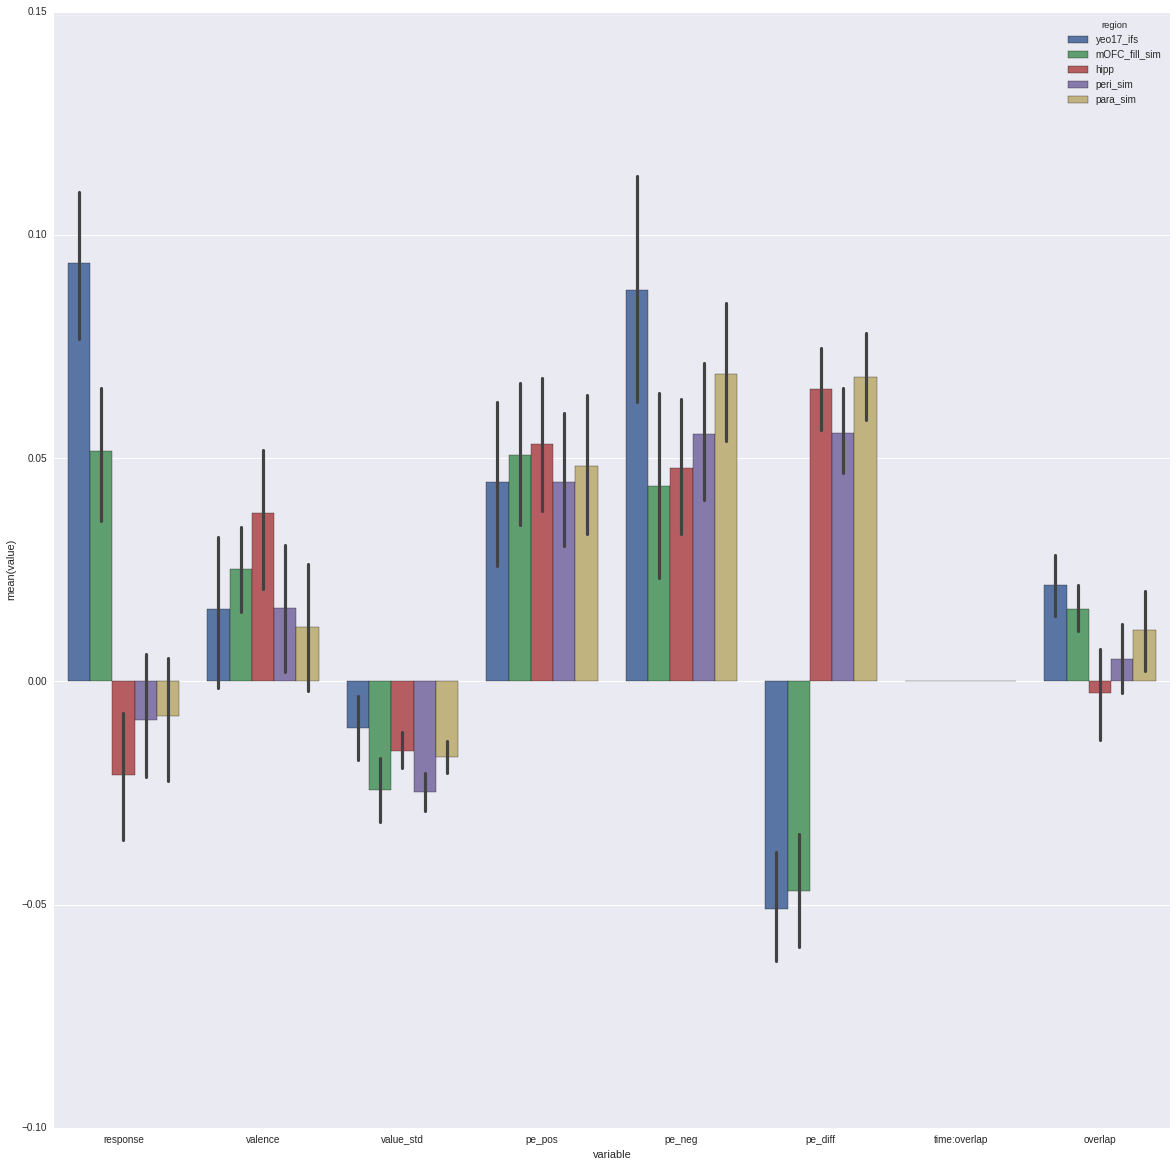

In [228]:
res_melt = pd.melt(res, id_vars=['region'], value_vars=['response','valence','value_std','pe_pos','pe_neg','pe_diff','time:overlap',
                                                       'overlap'
                                                       ])
sns.barplot(x='variable',y='value',hue = 'region',data = res_melt, ci = 68)
# plt.savefig('/home/iballard/Dropbox/fd/figs/value_RSA.png')

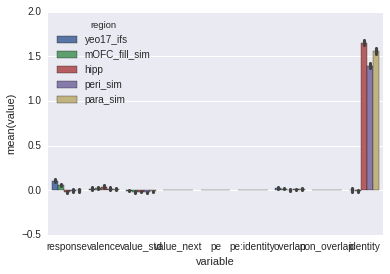

In [149]:
res_melt = pd.melt(res, id_vars=['region'], value_vars=['response','valence','value_std','value_next','pe','pe:identity',
                                                       'overlap','non_overlap','identity'
                                                       ])
# res_melt = pd.melt(res, id_vars=['region'], value_vars=pairs)

sns.barplot(x='variable',y='value',hue = 'region',data = res_melt, ci = 68)
# plt.savefig('/home/iballard/Dropbox/fd/figs/value_RSA.png')

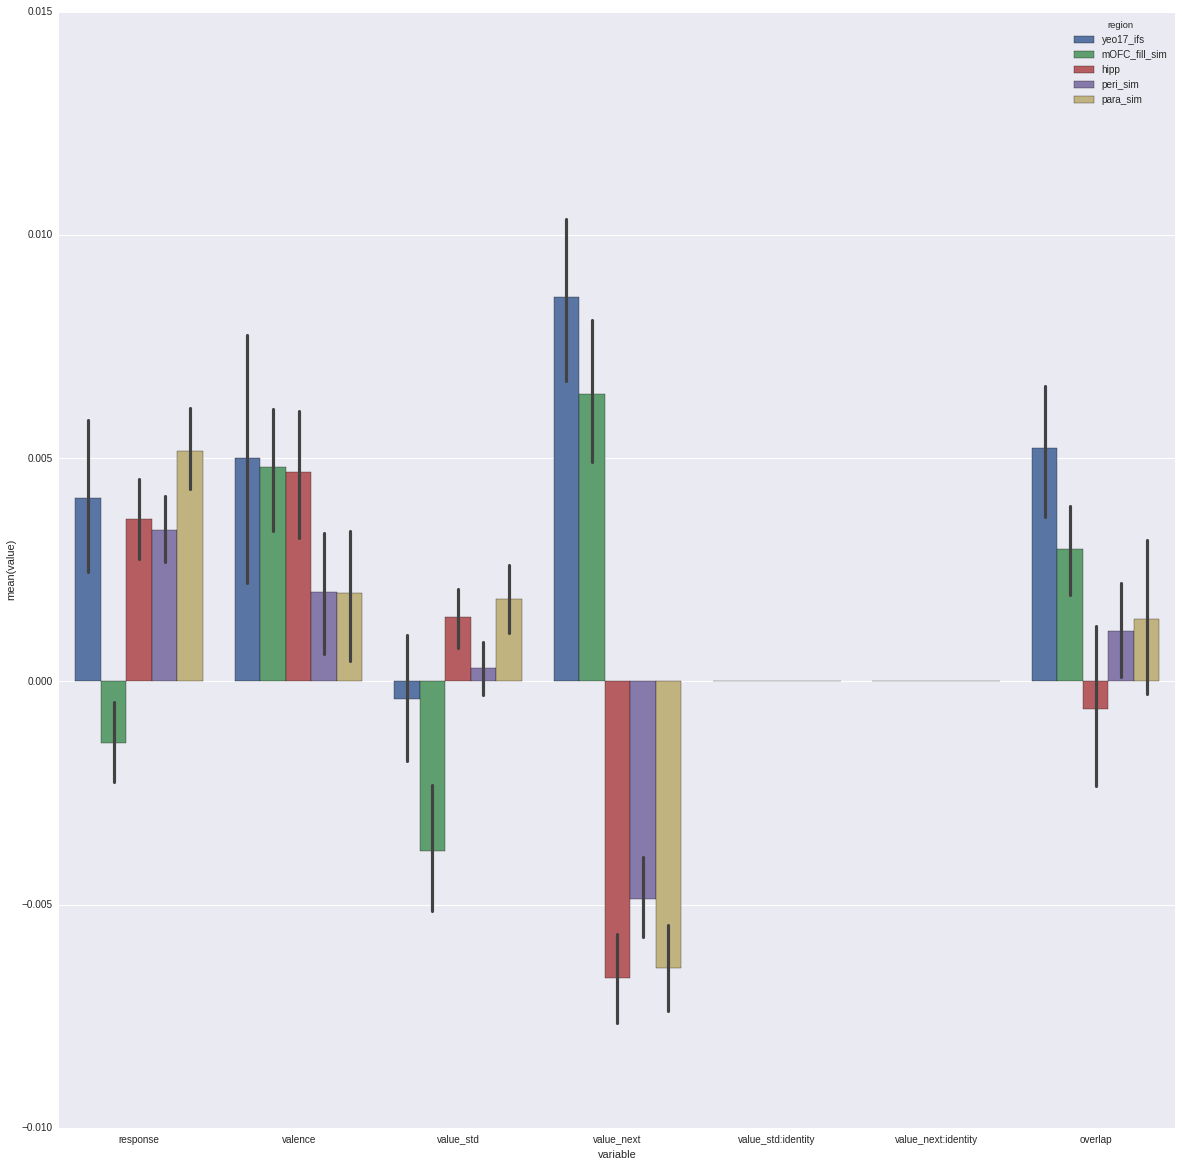

In [1233]:
res_melt = pd.melt(res, id_vars=['region'], value_vars=['response','valence','value_std','value_next','value_std:identity',
                                                       'value_next:identity','overlap'
                                                       ])
# res_melt = pd.melt(res, id_vars=['region'], value_vars=pairs)

sns.barplot(x='variable',y='value',hue = 'region',data = res_melt, ci = 68)


In [633]:
# # # m = mask_models[mask][sub].copy()
# mds_rsas = []
# for run in range(1,4):
#     mean_rsa = fig_rsas.loc['para_sim',1].groupby(['cond1','cond2']).mean()
#     mean_rsa = mean_rsa.unstack()['corr']
#     mean_rsa = 1 - mean_rsa

#     # pos = mds.fit(mean_rsa)
#     for c1 in mean_rsa.index.values:
#         for c2 in mean_rsa.index.values:
#             if np.isnan(mean_rsa[c1][c2]):
#                 mean_rsa[c1][c2] = mean_rsa[c2][c1]
#     mds_rsas.append(mean_rsa.values) 
    
# mds_rsas = np.mean(mds_rsas,0)
# # mds = manifold.MDS(metric = True, n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=-1, n_init = 1000)
# # pos = mds.fit_transform(mds_rsas)

# # # Rotate the data
# # clf = PCA(n_components=2)
# # pos = clf.fit_transform(pos)

In [1356]:
mean_rsa = resid_df[resid_df['run_idx'] == 2]
mean_rsa = mean_rsa.groupby(['cond1','cond2']).mean()['resid'].unstack()

for c1 in mean_rsa.index.values:
    for c2 in mean_rsa.index.values:
        if c1 == c2:
            mean_rsa[c1][c2] = 0
        if np.isnan(mean_rsa[c1][c2]):
            mean_rsa[c1][c2] = mean_rsa[c2][c1]

mds = manifold.MDS(metric = True, n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=-1, n_init = 1000)
pos = mds.fit_transform(mean_rsa)

# Rotate the data
clf = PCA(n_components=2)
pos = clf.fit_transform(pos)

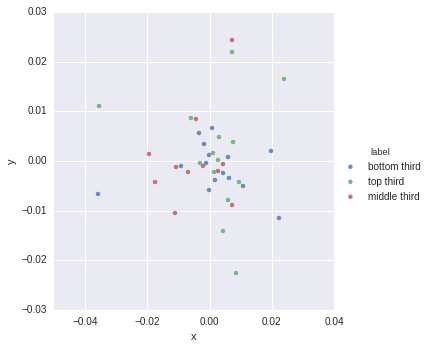

In [1358]:
label = [x.split('_')[0] for x in mean_rsa.index.values]
results = pd.DataFrame({'x':pos[:,0],'y':pos[:,1],'label' :V_categorical})
sns.lmplot('x','y', hue = 'label', fit_reg = False, data = results)

In [1357]:
# RL_std.loc[1]
labels = mean_rsa.index.values
Vs = []
order = []
for l in labels:
    c,n = l.split('_')
    V = RL_next.loc[(2,reverse_name_map[c]),'V'].values[int(n)]
    Vs.append(str(round(V,2)))
    
    if int(n)<=3:
        order.append('first')
    elif int(n)<=6:
        order.append('second')
    else:
        order.append('last')
        
# V_categorical = []
# for v in Vs:
#     if float(v) > np.percentile(map(float,Vs),90):
#         V_categorical.append('+')
#     elif float(v) < np.percentile(map(float,Vs),10):
#         V_categorical.append('+')
#     else:
#         V_categorical.append('0')

V_categorical = []
for v in Vs:
    if float(v) > np.percentile(map(float,Vs),66):
        V_categorical.append('top third')
    elif float(v) < np.percentile(map(float,Vs),33):
        V_categorical.append('middle third')
    else:
        V_categorical.append('bottom third')



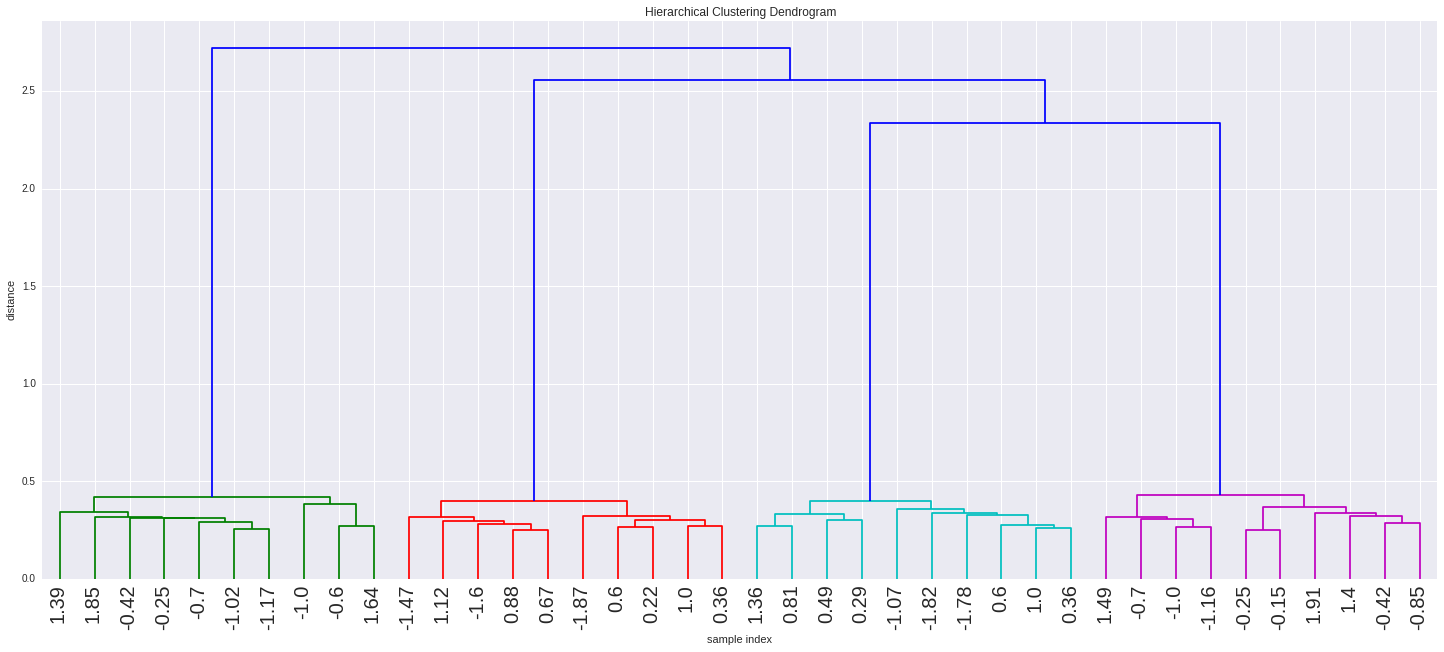

In [1185]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(mean_rsa.values, 'ward')
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    labels = Vs,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
)
plt.show()

In [128]:
rois= ['hipp','peri_sim','para_sim','entorhinal']
# rois= ['hipp']

res = {'intercept':[],'response':[],'valence':[],'overlap':[],'identity':[],'region':[],'sub':[]}
res_stacked = {'beta':[],'regressor':[],'region':[]}
for roi in rois:
    for sub,rsa in enumerate(all_rsas[roi]):
        data = pd.DataFrame()
        data['y'] = rsa[np.tril_indices_from(rsa)]
#         data['y'] = 1-rsa[np.tril_indices_from(rsa)]
        data['y'] = np.arctanh(data['y'])

        data['response'] = [1,0,1,0,1,1,1,0,0,1]
        data['valence'] = [1,0,-1,0,-1,-1,1,0,0,1]
        data['overlap'] = [0,1,0,1,0,0,0,1,0,0]
        data['identity'] = [1,0,1,0,0,1,0,0,0,1]
        data['double'] = [1,1,1,0,0,0,0,0,0,0]

        data['response'] = data['response'] - np.mean(data['response'])
        data['valence'] = data['valence'] - np.mean(data['valence'])
        data['overlap'] = data['overlap'] - np.mean(data['overlap'])
        data['identity'] = data['identity'] - np.mean(data['identity'])

        model = ols("y ~ identity + response + valence + overlap", data)    
        fit = model.fit()
        
        res['intercept'].append(fit.params['Intercept'])
        res['response'].append(fit.params['response'])
        res['valence'].append(fit.params['valence'])
        res['overlap'].append(fit.params['overlap'])
        res['identity'].append(fit.params['identity'])
        res['sub'].append(sub)
        res['region'].append(roi)
    
res = pd.DataFrame(res)
# res.to_csv('/home/iballard/Dropbox/fd/sim_similarity.csv')

In [129]:
# # rois= ['hipp','peri_sim','para_sim','entorhinal']
# rois= ['hipp']

# res = {'intercept':[],'response':[],'valence':[],'overlap':[],'region':[],'sub':[]}
# res_stacked = {'beta':[],'regressor':[],'region':[]}
# for roi in rois:
#     for sub,rsa in enumerate(all_rsas[roi]):
#         data = pd.DataFrame()
#         y = rsa[np.tril_indices_from(rsa)]
#         diag = [False,True,False,True,True,False,True,True,True,False]
#         data['y'] = [x for n,x in enumerate(y) if diag[n]]
        
#         data['response'] = [0,0,1,1,0,0]
#         data['valence'] = [0,0,-1,1,0,0]
#         data['overlap'] = [1,1,0,0,1,0]
# #         data['double'] = [1,1,1,0,0,0,0,0,0,0]


#         data['overlap'] = data['overlap'] - np.mean(data['overlap'])
#         model = ols("y ~  response + valence + overlap", data)    
#         fit = model.fit()
        
#         res['intercept'].append(fit.params['Intercept'])
#         res['response'].append(fit.params['response'])
#         res['valence'].append(fit.params['valence'])
#         res['overlap'].append(fit.params['overlap'])
#         res['sub'].append(sub)
#         res['region'].append(roi)
    
# res = pd.DataFrame(res)
# # res.to_csv('/home/iballard/Dropbox/fd/sim_similarity.csv')

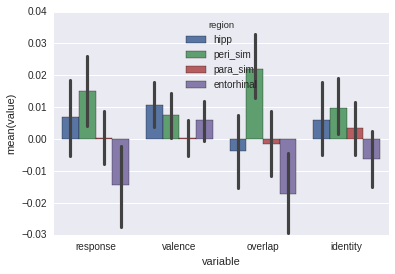

In [131]:
res_melt = pd.melt(res, id_vars=['region'], value_vars=['response','valence','overlap','identity'])
sns.barplot(x='variable',y='value',hue = 'region',data = res_melt, ci = 68)
# plt.savefig('/home/iballard/Dropbox/fd/RSA.png')